In [539]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [540]:
# read in all data (downloaded and renamed from joined_df in Github)
all_data = pd.read_csv('data_movie_reviews.csv')

# Data Exploration and Cleaning

In [541]:
# found a problem with filtering by year so checking those values
all_data['Year'].unique()

array(['2020', '2021', '2019', '2001', '2020–', '1930', '2013', '2018',
       '2016', '2005', '1945', '2017', '1980', '1981', '1979', '2004',
       '2014', '2007', '2010', '1976', '2012', '2000', '1992', '2008',
       '1982', '1978', '2015', '2011', '2021–', '1974'], dtype=object)

In [542]:
# remove dashes
all_data['Year'] = all_data['Year'].apply(lambda x: re.sub(r'[\W_]+', '', x))

In [543]:
# now let's explore some of the distributions of some of the variables
all_data.columns

Index(['Unnamed: 0', 'Title', 'Year', 'Rated', 'Released', 'Runtime_mins',
       'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country',
       'Awards', 'Poster', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes',
       'imdbID', 'Type', 'DVD', 'BoxOffice', 'Production', 'Website',
       'Response', 'totalSeasons', 'Internet Movie Database',
       'Rotten Tomatoes', 'Metacritic', 'oscar_wins', 'oscar_noms',
       'emmy_wins', 'emmy_noms', 'total_wins', 'total_noms', 'display_title',
       'mpaa_rating', 'critics_pick', 'byline', 'headline', 'summary_short',
       'publication_date', 'opening_date', 'date_updated', 'link',
       'multimedia', 'review_text'],
      dtype='object')

<AxesSubplot:>

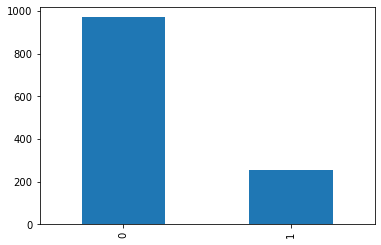

In [544]:
# critics pick (what we are predicting)
all_data['critics_pick'].value_counts().plot(kind = 'bar')
# looks like most are not critics pick

In [545]:
set(all_data['Rated'])

{'G',
 'MA-17',
 'Not Rated',
 'PG',
 'PG-13',
 'R',
 'TV-14',
 'TV-G',
 'TV-MA',
 'TV-PG',
 'TV-Y7',
 'Unrated',
 nan}

<AxesSubplot:>

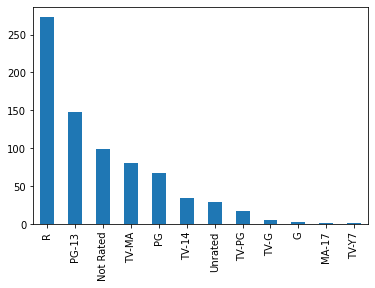

In [546]:
# rating
all_data['Rated'].value_counts().plot(kind = 'bar')

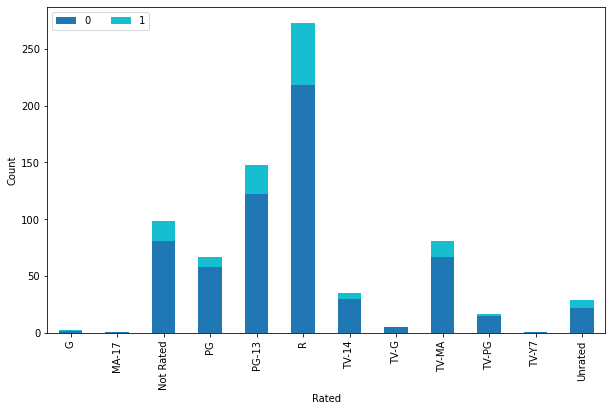

In [547]:
# now we can look at each by critics choice -- doesn't look like huge chunk of any one genre has critics choice
cross_tab_prop = pd.crosstab(index=all_data['Rated'],
                             columns=all_data['critics_pick'])
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Rated")
plt.ylabel("Count")
plt.show()

In [548]:
list(set(all_data['Rated']))

[nan,
 'PG-13',
 'PG',
 'G',
 'TV-G',
 'TV-MA',
 'TV-14',
 'R',
 'Unrated',
 'TV-PG',
 'Not Rated',
 'MA-17',
 'TV-Y7']

In [549]:
# now create a variable for each rating and assign 1 if that rating
for rating in list(set(all_data['Rated'])):
    values = []
    for listed_rating in all_data['Rated']:
            if listed_rating == rating:
                values.append(1)
            else:
                values.append(0)
    all_data[rating] = values

In [550]:
# Genre
all_data['Genre'].value_counts()

Documentary                  233
Drama                        144
Comedy, Drama                 46
Comedy                        28
Drama, Horror, Mystery        27
                            ... 
Action, Comedy, Horror         1
Drama, Family, Fantasy         1
Documentary, Crime, Sport      1
Comedy, Family, Romance        1
Short, Comedy                  1
Name: Genre, Length: 235, dtype: int64

In [551]:
# let's clean that up a bit
# find the unique genres
all_genres = []
all_data['Genre'] = all_data['Genre'].astype(str)
for genres_string in list(all_data['Genre']):
    genre_list = genres_string.split(',')
    for genre in genre_list:
        all_genres.append(genre.strip())
unique_genres = list(set(all_genres))
unique_genres

['Documentary',
 'Drama',
 'Sport',
 'Mystery',
 'Action',
 'Animation',
 'Thriller',
 'Family',
 'Western',
 'Comedy',
 'Fantasy',
 'Romance',
 'Crime',
 'History',
 'Talk-Show',
 'Adventure',
 'War',
 'Musical',
 'Music',
 'Horror',
 'Biography',
 'Short',
 'Sci-Fi',
 'nan']

In [552]:
# now create a variable for each genre and assign 1 if listed for genre description
for genre in unique_genres:
    values = []
    for genre_description in all_data['Genre']:
        if genre in genre_description:
            values.append(1)
        else:
            values.append(0)
    all_data[genre] = values

In [553]:
# moving genre to end of dataframe with assignments
genre = all_data.pop('Genre')
all_data['genre'] = genre

In [554]:
# now viewing changes made
all_data.iloc[: , -25:]

,Documentary,Drama,Sport,Mystery,Action,Animation,Thriller,Family,Western,Comedy,...,Adventure,War,Musical,Music,Horror,Biography,Short,Sci-Fi,nan,genre
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,"Action, Sci-Fi, Thriller"
1,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,"Action, Adventure, Drama"
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,"Action, Adventure, Fantasy"
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,"Animation, Adventure, Comedy"
4,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,"Animation, Adventure, Comedy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"Short, Action"
1223,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"Short, Drama"
1224,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Crime, Drama"
1225,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Action, Crime, Drama"


In [555]:
# looks good! we'll remove the nan column as it is not needed
all_data = all_data.drop(columns = ['nan'])

In [556]:
# now we can look at the distribution of the genres
genres_df = all_data.iloc[: , -24:-1]
genres_df

,Documentary,Drama,Sport,Mystery,Action,Animation,Thriller,Family,Western,Comedy,...,History,Talk-Show,Adventure,War,Musical,Music,Horror,Biography,Short,Sci-Fi
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1223,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1224,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1225,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

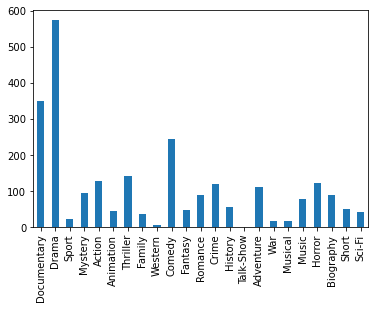

In [557]:
genres_df.sum().plot(kind = 'bar')

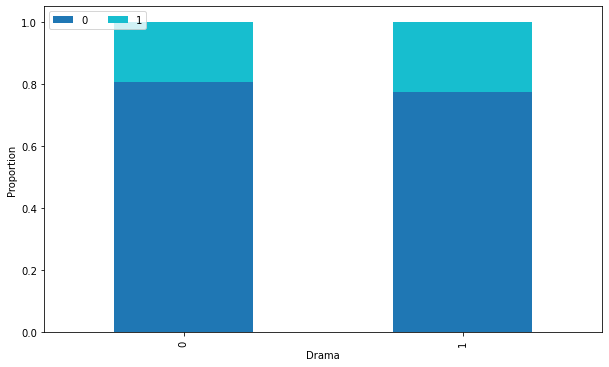

In [558]:
# looking at a couple of genres where critics pick
cross_tab_prop = pd.crosstab(index=all_data['Drama'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Drama")
plt.ylabel("Proportion")
plt.show()

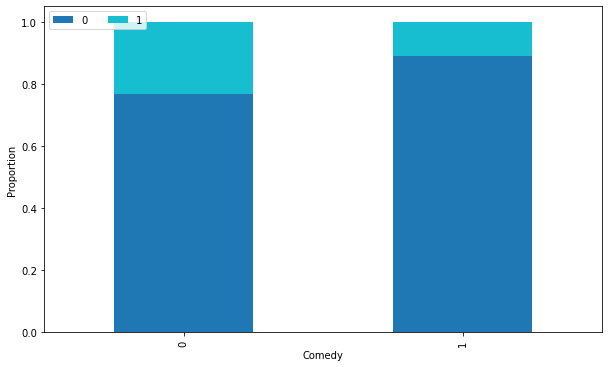

In [559]:
cross_tab_prop = pd.crosstab(index=all_data['Comedy'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Comedy")
plt.ylabel("Proportion")
plt.show()

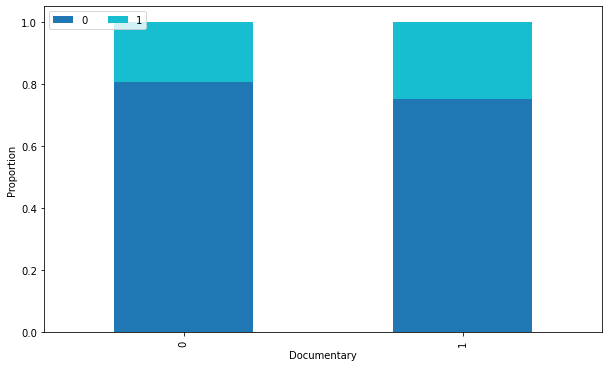

In [560]:
cross_tab_prop = pd.crosstab(index=all_data['Documentary'],
                             columns=all_data['critics_pick'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Documentary")
plt.ylabel("Proportion")
plt.show()

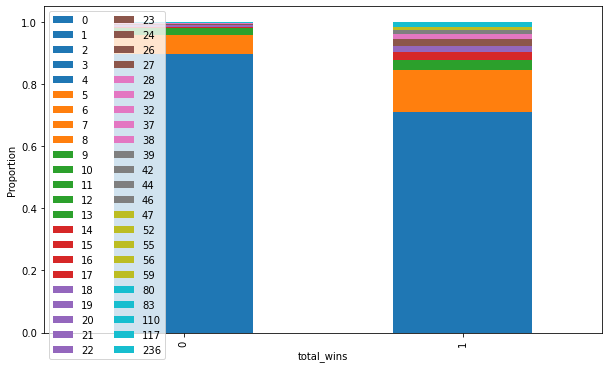

In [561]:
# now looking at wins
cross_tab_prop = pd.crosstab(index=all_data['critics_pick'],
                             columns=all_data['total_wins'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("total_wins")
plt.ylabel("Proportion")
plt.show()

# it's a little rough looking with no filtering but we can see that movies not critics pick have less wins than critics picks

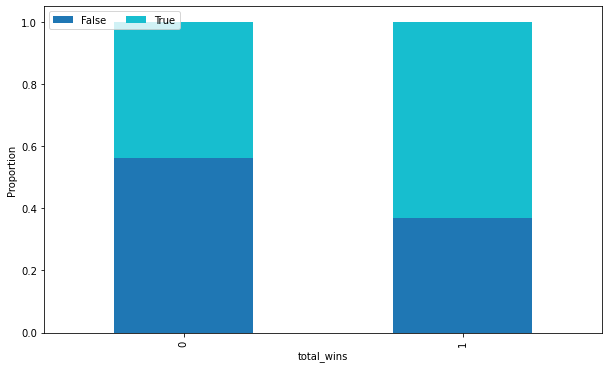

In [562]:
# let's create a new category for "won_something"
all_data['won_something'] = all_data['total_wins'].apply(lambda x: True if int(x) > 0 else False)

# now plot as above
cross_tab_prop = pd.crosstab(index=all_data['critics_pick'],
                             columns=all_data['won_something'],
                            normalize = 'index')
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("total_wins")
plt.ylabel("Proportion")
plt.show()

<AxesSubplot:ylabel='Frequency'>

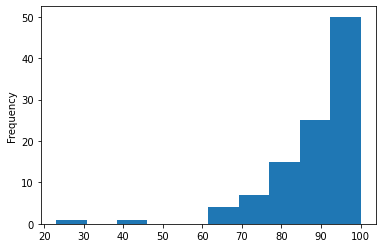

In [563]:
# distribution of rotten tomatoes by critics choice (the picks)
all_data[all_data['critics_pick'] == 1]['Rotten Tomatoes'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

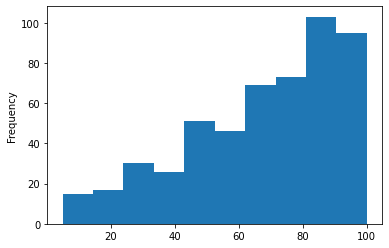

In [564]:
# distribution of rotten tomatoes by critics choice (not picked)
all_data[all_data['critics_pick'] == 0]['Rotten Tomatoes'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

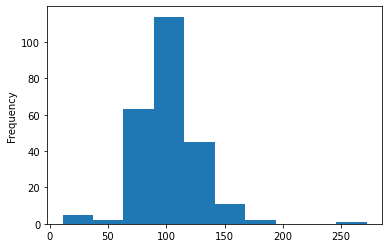

In [565]:
# now runtime minutes (picked)
all_data[all_data['critics_pick'] == 1]['Runtime_mins'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

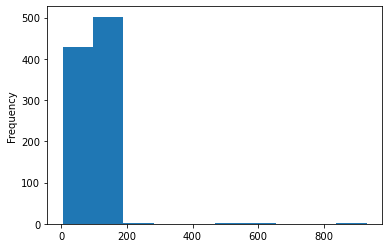

In [566]:
# now runtime minutes (not picked)
all_data[all_data['critics_pick'] == 0]['Runtime_mins'].plot(kind = 'hist')
# some obvious skew issues here, but not exploring just yet

# Modeling

In [567]:
# split into train and test (train on 2020, test on 2021)
train = all_data[all_data['Year'] == '2020']
test = all_data[all_data['Year'] == '2021']

# view counts for each
print('train count: ', len(train))
print('test count: ', len(test))

train count:  484
test count:  436


In [568]:
# having trouble adding runtime mins -- come back later
train_X = train[['Documentary',
                 'Drama',
                 'Thriller',
                 'Comedy',
                'total_wins']]
train_y = train['critics_pick']

In [569]:
test_X = test[['Documentary',
             'Drama',
             'Thriller',
             'Comedy',
              'total_wins']]
test_y = test['critics_pick']

In [570]:
model = LogisticRegression(solver='liblinear', random_state=42)

In [571]:
model.fit(train_X, train_y)

LogisticRegression(random_state=42, solver='liblinear')

In [575]:
y_pred = model.predict(test_X)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [583]:
report = classification_report(test_y, y_pred)
print('report:', report, sep='\n')

report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       355
           1       1.00      0.01      0.02        81

    accuracy                           0.82       436
   macro avg       0.91      0.51      0.46       436
weighted avg       0.85      0.82      0.74       436



In [587]:
test_y.value_counts()

0    355
1     81
Name: critics_pick, dtype: int64

In [591]:
pd.Series(y_pred).value_counts()

0    435
1      1
dtype: int64